# Initial Model Selection

In [1]:
#First set some useful variables and import required libraries
KAGGLE=False # set to True if using the Kaggle version of the dataset
WRITE=False
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import sklearn.preprocessing

from sklearn.pipeline import make_pipeline 
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, StratifiedKFold,KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import catboost as cb

from xgboost import XGBRegressor
import pickle

import shap
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 300)
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression,Lasso, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score,KFold, train_test_split
from sklearn.pipeline import Pipeline
plt.rcParams["figure.figsize"] = (20, 10)
from tqdm import tqdm


The data has been pre-processed

In [2]:
alldata=pd.read_csv('./data/Ames_HousePriceLocsDistNoDpl.csv')#, index_col=0) #already cleaned (see work in appendix files)

In [3]:
alldata_lasso=alldata.drop(['2ndFlrSF'],axis=1)

If working with the Kaggle version of the dataset, can use the function below to do train-test split

In [4]:
def label_encode(data):
    from sklearn import preprocessing
    le = preprocessing.LabelEncoder()
    for column_name in data.columns:
        if data[column_name].dtype == object:
            #cat_idxs.append(alldata.columns.get_loc(column_name))
            #alldata[column_name] = alldata[column_name].astype(str)
            data[column_name] = le.fit_transform(data[column_name])
label_encode(alldata_lasso)
label_encode(alldata)

In [5]:
def train_test_split_custom(data=alldata,y_var='SalePrice',cols=[]):
    y=data[y_var]
    X=data.drop([y_var],axis=1)
    X= X if not cols else X[cols]
    return train_test_split(X, y, test_size=0.2, random_state=42)


# Initial Model Comparisons

In [6]:
from random import shuffle
scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split_custom(data=alldata_lasso)  
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = {"Lasso":Lasso(alpha=.1),
"Linear":LinearRegression(),
"RF":RandomForestRegressor(min_samples_leaf=5),
"XGB":xgb.XGBRFRegressor(max_depth=10)}
results = []
for model in tqdm(models.values()):
    kf = KFold(n_splits=5,random_state=43,shuffle=True)
    cv_results = cross_val_score(model, X_train_scaled, y_train, cv=kf)
    results.append(cv_results)
plt.boxplot(results, labels = models.keys())
plt.show()

  0%|          | 0/4 [00:00<?, ?it/s]

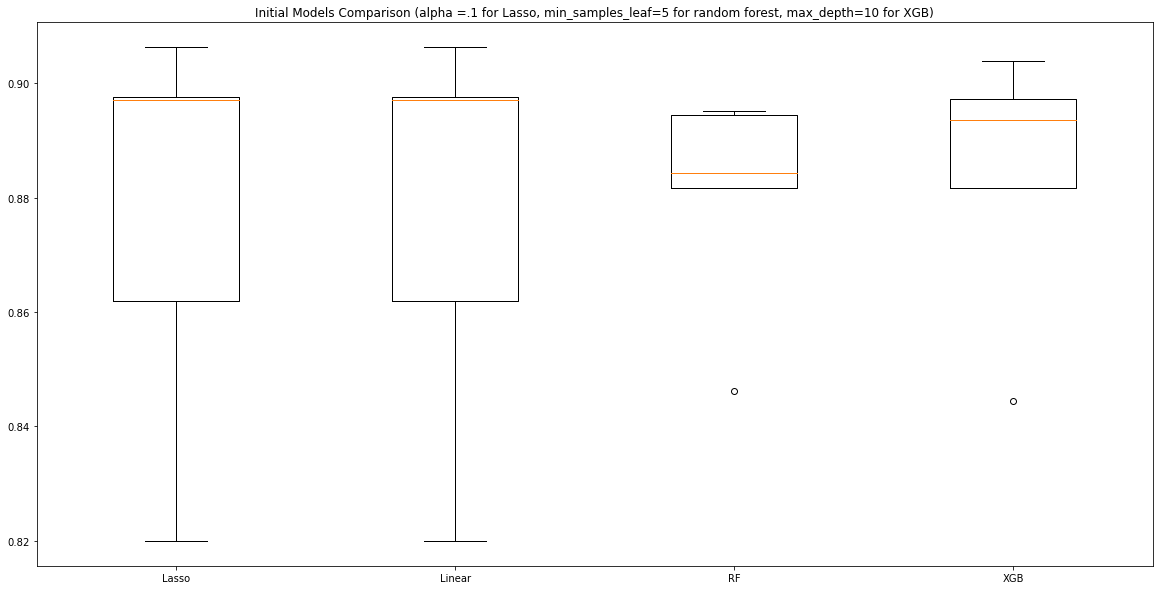

In [7]:
plt.boxplot(results, labels = models.keys())
plt.title('Initial Models Comparison (alpha =.1 for Lasso, min_samples_leaf=5 for random forest, max_depth=10 for XGB)')
plt.show()

In [8]:
alldata_ = alldata_lasso
alldata_['LogPrice']=np.log1p(alldata_.SalePrice)
alldata_.drop(['SalePrice'],axis=1,inplace=True)

100%|██████████| 4/4 [00:31<00:00,  7.92s/it]


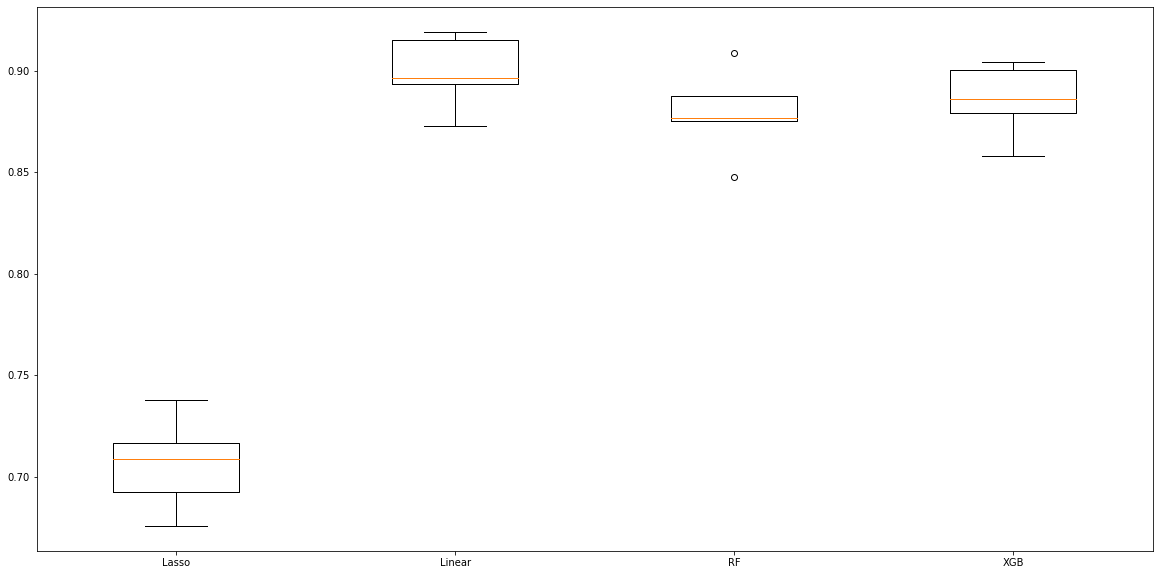

In [7]:
from random import shuffle
scaler = StandardScaler()
alldata_ = alldata_lasso
X_train, X_test, y_train, y_test = train_test_split_custom(data=alldata_,y_var='LogPrice')  
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = {"Lasso":Lasso(alpha=.1),
"Linear":LinearRegression(),
"RF":RandomForestRegressor(min_samples_leaf=5),
"XGB":xgb.XGBRFRegressor(max_depth=10)}
results = []
for model in tqdm(models.values()):
    kf = KFold(n_splits=5,random_state=43,shuffle=True)
    cv_results = cross_val_score(model, X_train_scaled, y_train, cv=kf)
    results.append(cv_results)
plt.boxplot(results, labels = models.keys())
plt.show()

# Lasso Feature Importances

<AxesSubplot:>

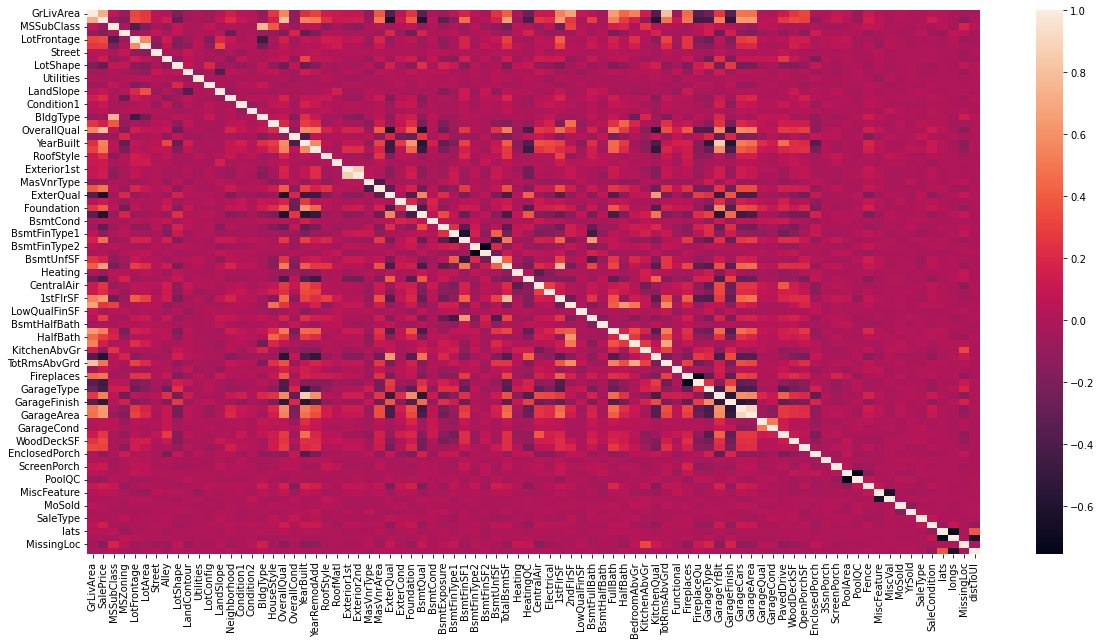

In [9]:
sns.heatmap(alldata.corr())


In [11]:
scaler=StandardScaler()
alldata_ = alldata_lasso
X_train, X_test, y_train, y_test = train_test_split_custom(data=alldata_,y_var='LogPrice')  
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


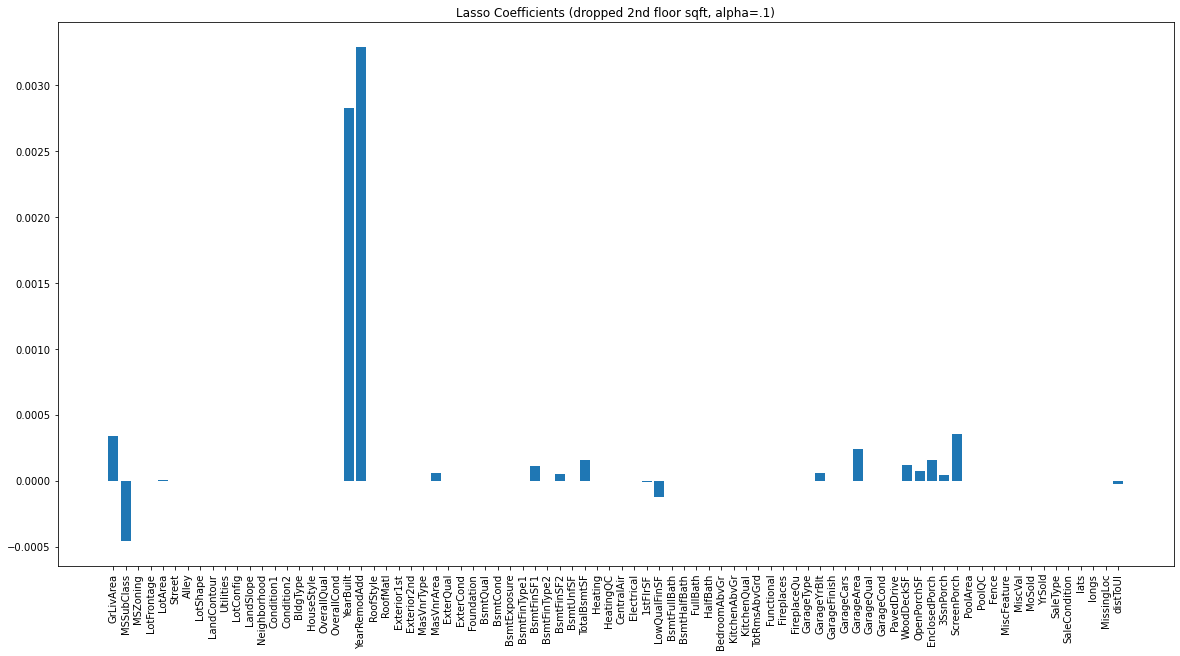

In [12]:
lasso = Lasso(alpha=0.1,max_iter=10000)
y=alldata_['LogPrice'].values
X=alldata_.drop(['LogPrice'],axis=1).values
names = alldata_.drop(['LogPrice'],axis=1).columns
lasso_coef = lasso.fit(X,y).coef_
plt.bar(names, lasso_coef)
plt.title('Lasso Coefficients (dropped 2nd floor sqft, alpha=.1)')
plt.xticks(rotation=90)
plt.show()

In [13]:
# lasso = Lasso(alpha=0.5,max_iter=10000)
# y=alldata['SalePrice'].values
# X=alldata.drop(['SalePrice','2ndFlrSF'],axis=1).values
# names = alldata.drop(['SalePrice','2ndFlrSF'],axis=1).columns
# lasso_coef = lasso.fit(X,y).coef_
# plt.bar(names, lasso_coef)
# plt.title('Lasso Coefficients (dropped 2nd floor sqft, alpha=.1)')
# plt.xticks(rotation=90)
# plt.show()

In [18]:
X_train, X_test, y_train, y_test = train_test_split_custom(data=alldata_,y_var='LogPrice')  

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
rfe = RFE(estimator=Lasso(alpha=0.3,max_iter=10000), n_features_to_select=30,step=10,verbose=1)
lasso_coef=rfe.fit(X_train,y_train)
cols_selected_lasso=list(X_train.columns[rfe.support_])

#cols_selected_lasso

Fitting estimator with 82 features.
Fitting estimator with 72 features.
Fitting estimator with 62 features.
Fitting estimator with 52 features.
Fitting estimator with 42 features.
Fitting estimator with 32 features.


In [19]:
cols_selected_lasso

['GrLivArea',
 'MSSubClass',
 'MSZoning',
 'LotFrontage',
 'LotArea',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'HouseStyle',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'TotalBsmtSF',
 'LowQualFinSF',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 'ScreenPorch',
 'YrSold',
 'SaleType']

Text(0.5, 1.0, 'Correlations of Features Selected by Lasso with Sale Price')

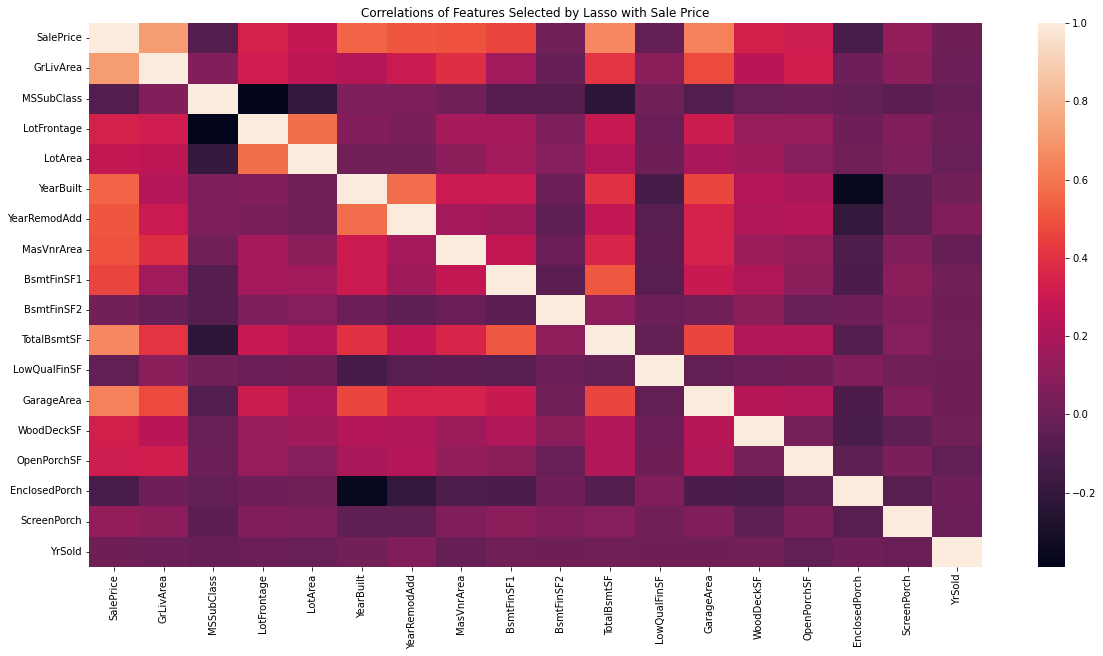

In [20]:
#alldata[cols_selected_lasso].corr()
sns.heatmap(alldata[['SalePrice']+cols_selected_lasso].corr())
plt.title("Correlations of Features Selected by Lasso with Sale Price")


In [21]:
alldata_lasso2 = pd.DataFrame()
alldata_lasso2['LogPrice'] = np.log1p(alldata['SalePrice'])
alldata_lasso2=pd.concat([alldata_lasso2,alldata[cols_selected_lasso]],axis=1)
#alldata_lasso2.drop(['SalePrice'],axis=1)

Text(0.5, 1.0, 'Correlations of Features Selected by Lasso with Log of Sale Price')

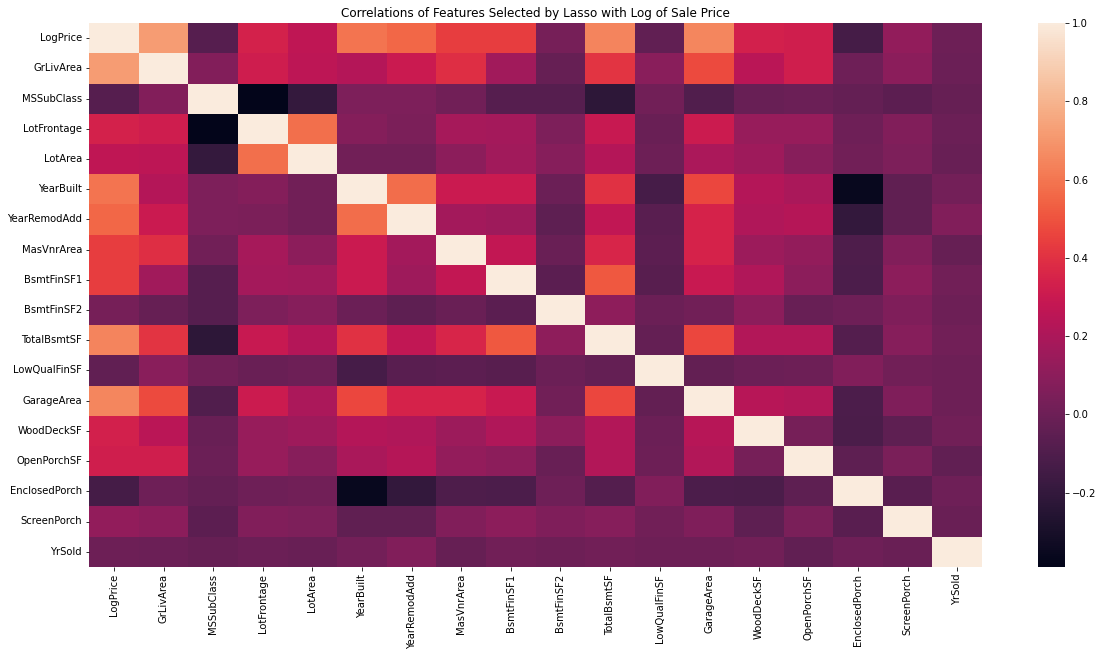

In [22]:
sns.heatmap(alldata_lasso2.corr())
plt.title("Correlations of Features Selected by Lasso with Log of Sale Price")


In [23]:
cols_selected_lasso=list(X_train.columns[rfe.support_])


# Random Forests

### First fit the 'full' version, which overfits 

In [24]:
def run_model(model,X_train,y_train,X_test,y_test):
    
    # Fit Model
    model.fit(X_train,y_train)
    
    # Get Metrics
    
    preds = model.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test,preds))
    print(f'RMSE : {rmse}')
    r2 = r2_score(y_test, preds)
    print(f'R^2 : {r2}')

    return model

In [25]:
from sklearn.ensemble import RandomForestRegressor
model_rf = RandomForestRegressor(min_samples_leaf=5)
run_model(model_rf,X_train,y_train,X_test,y_test)

RMSE : 0.1315083369909796
R^2 : 0.8888184476088414


RandomForestRegressor(min_samples_leaf=5)

In [26]:
if WRITE:
    pickle.dump(model_rf, open('./models/model_rf_locs_dist_nodpl', 'wb'))


In [27]:
importances = {}
importances['y'] = pd.Series(model_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
importances['y']

OverallQual      0.594400
GrLivArea        0.095177
GarageArea       0.070347
1stFlrSF         0.035419
TotalBsmtSF      0.033762
GarageCars       0.025819
BsmtFinSF1       0.014499
LotArea          0.014418
OverallCond      0.009573
YearRemodAdd     0.007774
YearBuilt        0.006700
FullBath         0.006612
MSZoning         0.006013
GarageType       0.005535
KitchenQual      0.004550
CentralAir       0.004214
longs            0.004106
LotFrontage      0.003684
GarageFinish     0.003668
OpenPorchSF      0.003405
BsmtUnfSF        0.003279
distToUI         0.003266
GarageYrBlt      0.003264
lats             0.003164
Neighborhood     0.002828
WoodDeckSF       0.002823
FireplaceQu      0.002475
MasVnrArea       0.002393
BsmtQual         0.002309
MSSubClass       0.002096
BsmtFinType1     0.002031
Fireplaces       0.001869
MoSold           0.001300
BsmtFullBath     0.001279
HeatingQC        0.001190
ExterQual        0.001107
TotRmsAbvGrd     0.000967
BsmtExposure     0.000888
PavedDrive  

## Now recursively select features to build a more generalizable model that suffers less from overfitting

In [28]:
rfe = RFE(estimator=RandomForestRegressor(min_samples_leaf=10),
n_features_to_select=30,step=10,verbose=1)
rfe.fit(X_train,y_train)

Fitting estimator with 82 features.
Fitting estimator with 72 features.
Fitting estimator with 62 features.
Fitting estimator with 52 features.
Fitting estimator with 42 features.
Fitting estimator with 32 features.


RFE(estimator=RandomForestRegressor(min_samples_leaf=10),
    n_features_to_select=30, step=10, verbose=1)

In [29]:
rfe.score(X_test,y_test)

0.8840646683439419

- Notice that R^2 is .8925 vs. .9067 for the 'full' model.  Thus the R^2 are similar, yet the model with only 20 features and a minimum of at least 10 observations in each node 
- Does it overfit?

In [30]:
rfe.score(X_train,y_train)

0.9217485019307904

In [31]:
cols_selected_rf=list(X_train.columns[rfe.support_])

In [36]:
y=alldata['SalePrice']
X=alldata.drop(['SalePrice'],axis=1)
X_rf=X[cols_selected_rf]
X_train, X_test, y_train, y_test =  train_test_split(X_rf, y, test_size=0.2, random_state=42)

In [37]:
rf=rfe.estimator.fit(X_train,y_train)
rf.score(X_test,y_test)

0.8921295242194596

- Can train an RF on 20 most important features with little overfitting (under 3% train-test difference)

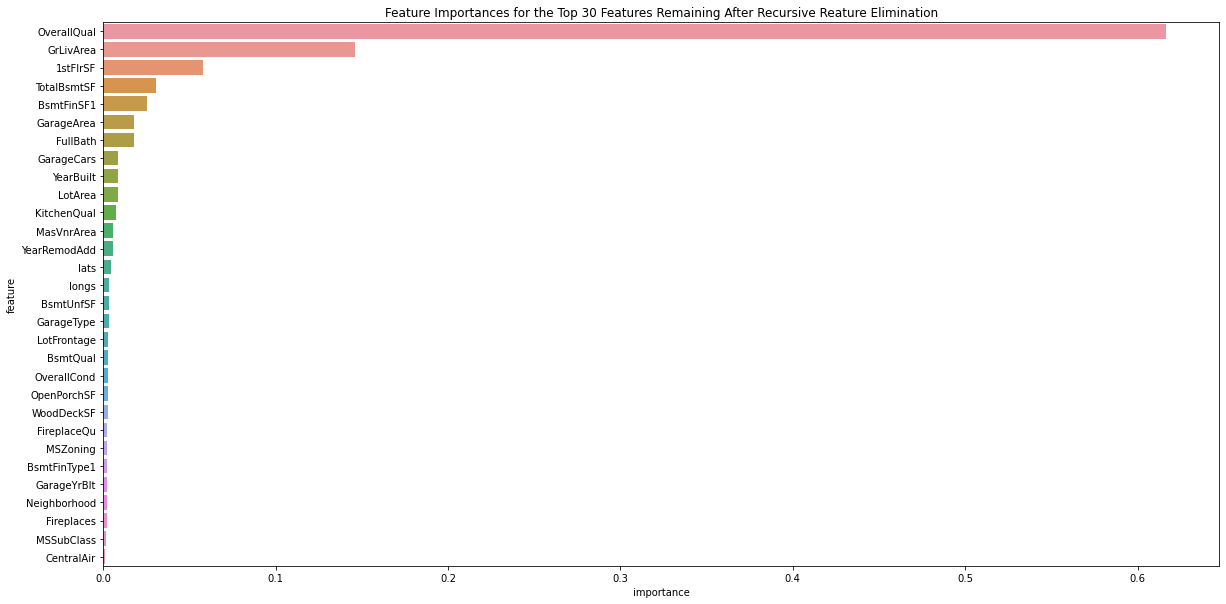

In [38]:
feature_importances = pd.DataFrame({'feature':list(X_test.columns),
                                    'importance':rf.feature_importances_}).sort_values('importance', ascending=False)
sns.barplot(data=feature_importances,x='importance',y='feature')
plt.title("Feature Importances for the Top 30 Features Remaining After Recursive Reature Elimination")
plt.show()


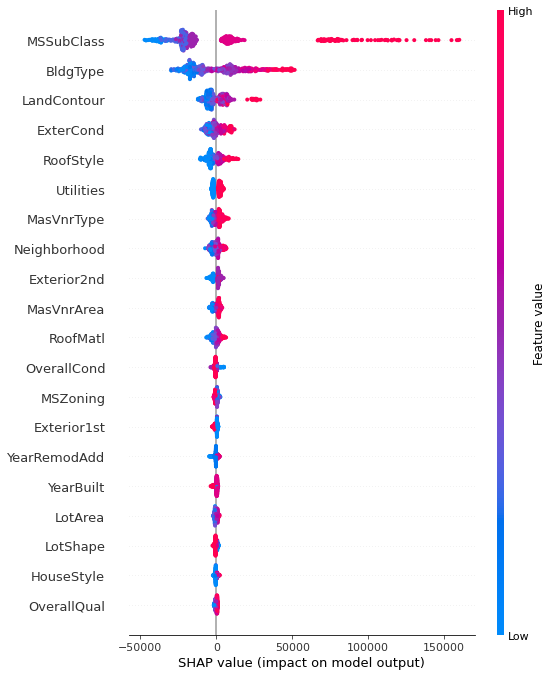

In [39]:
sorted_feature_importance_rf = rf.feature_importances_.argsort()
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names = alldata.columns[sorted_feature_importance_rf])

## Select columns both random forests and Lasso considered important

In [41]:
len(cols_selected)

46

In [43]:
# from random import shuffle

# scaler = StandardScaler()
# X_train, X_test, y_train, y_test = train_test_split_custom(cols=cols_selected)  
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.fit_transform(X_test)

# models = {"Lasso":Lasso(alpha=.5,max_iter=10000),
# "Linear":LinearRegression(),
# "RF":RandomForestRegressor(min_samples_leaf=5),
# "XGB":xgb.XGBRFRegressor(max_depth=10)}
# results = []
# for model in models.values():
#     kf = KFold(n_splits=5,random_state=43,shuffle=True)
#     cv_results = cross_val_score(model, X_train_scaled, y_train, cv=kf)
#     results.append(cv_results)
# plt.boxplot(results, labels = models.keys())
# plt.show()

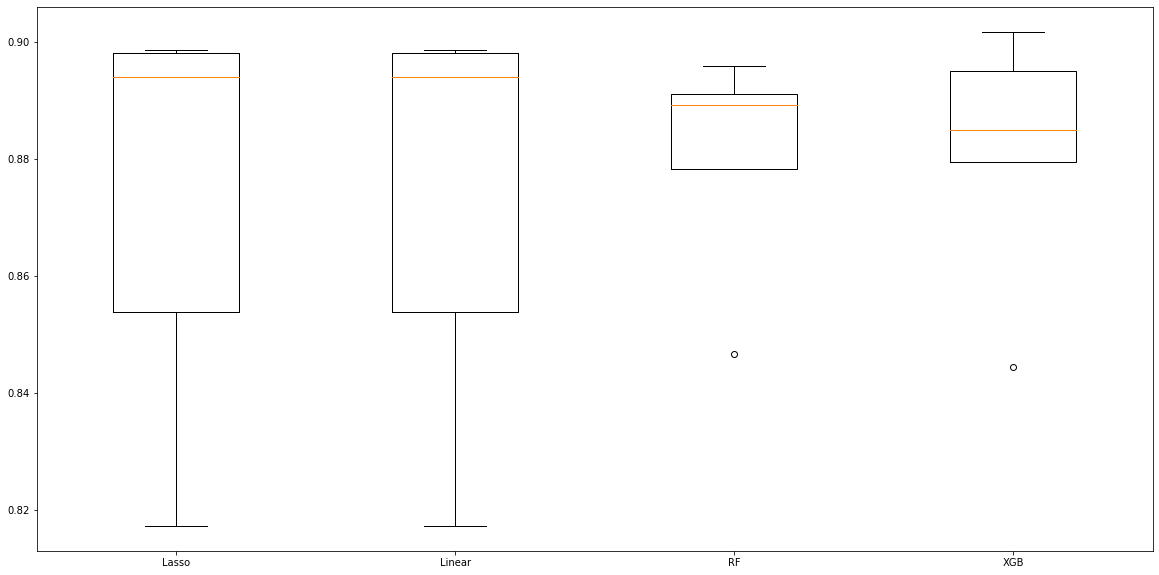

In [78]:
# from random import shuffle
# scaler = StandardScaler()
# X_train, X_test, y_train, y_test = train_test_split_custom(cols=cols_selected_rf)  
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.fit_transform(X_test)

# models = {"Lasso":Lasso(alpha=.5,max_iter=10000),
# "Linear":LinearRegression(),
# "RF":RandomForestRegressor(min_samples_leaf=5),
# "XGB":xgb.XGBRFRegressor(max_depth=10)}
# results = []
# for model in models.values():
#     kf = KFold(n_splits=5,random_state=43,shuffle=True)
#     cv_results = cross_val_score(model, X_train_scaled, y_train, cv=kf)
#     results.append(cv_results)
# plt.boxplot(results, labels = models.keys())
# plt.show()

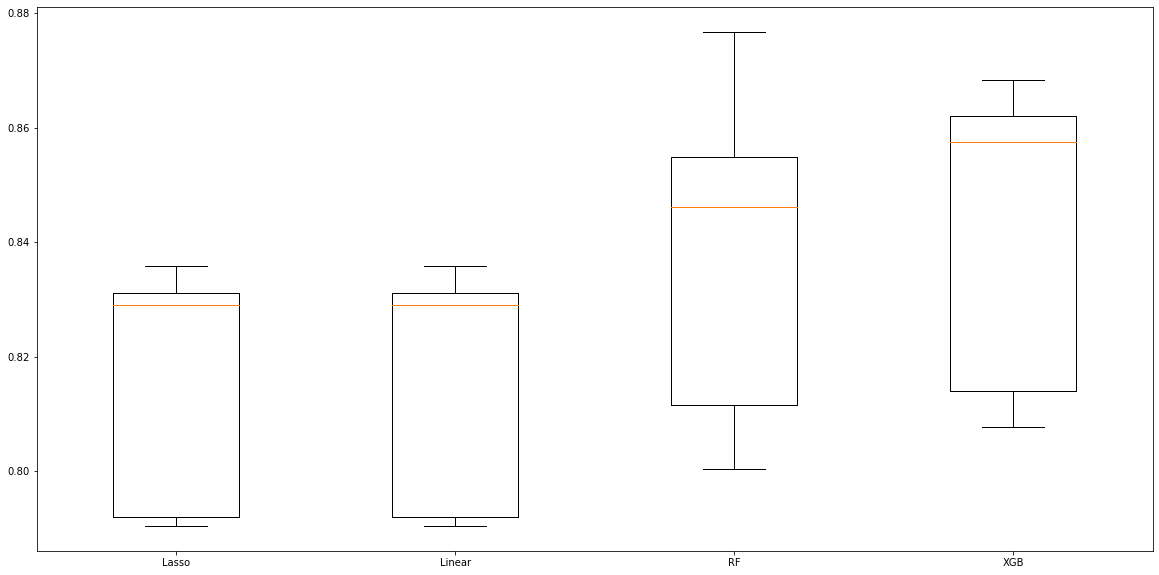

In [79]:
# from random import shuffle
# scaler = StandardScaler()
# X_train, X_test, y_train, y_test = train_test_split_custom(cols=cols_selected_lasso)  
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.fit_transform(X_test)

# models = {"Lasso":Lasso(alpha=.5,max_iter=10000),
# "Linear":LinearRegression(),
# "RF":RandomForestRegressor(min_samples_leaf=5),
# "XGB":xgb.XGBRFRegressor(max_depth=10)}
# results = []
# for model in models.values():
#     kf = KFold(n_splits=5,random_state=43,shuffle=True)
#     cv_results = cross_val_score(model, X_train_scaled, y_train, cv=kf)
#     results.append(cv_results)
# plt.boxplot(results, labels = models.keys())
# plt.show()

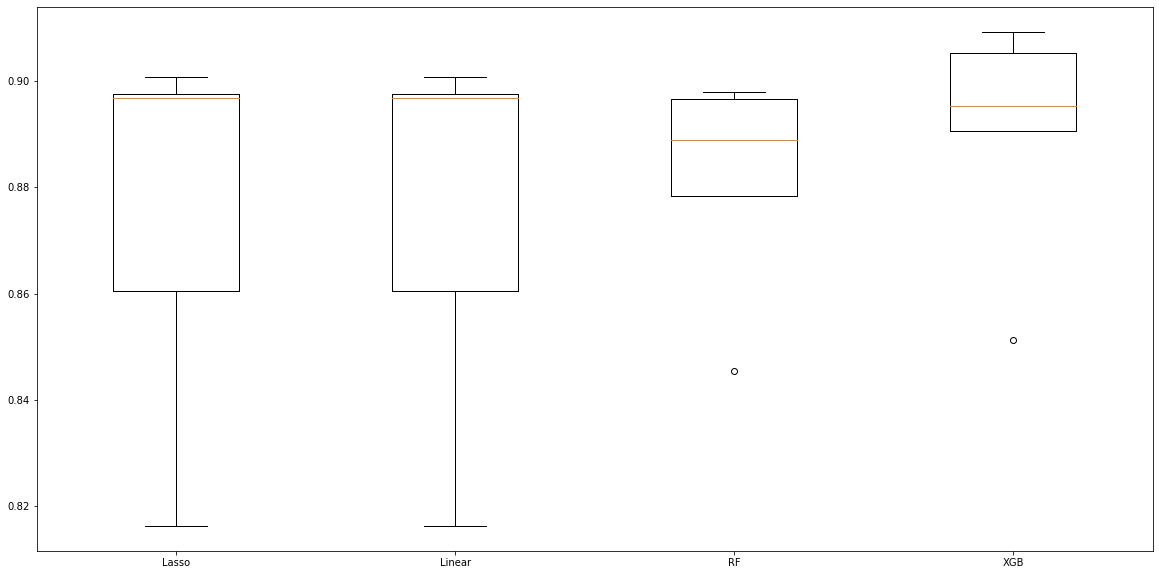

In [72]:
# from random import shuffle

# scaler = StandardScaler()
# X_train, X_test, y_train, y_test = train_test_split_custom(cols=cols_selected)  
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.fit_transform(X_test)

# models = {"Lasso":Lasso(alpha=.5,max_iter=10000),
# "Linear":LinearRegression(),
# "RF":RandomForestRegressor(min_samples_leaf=5),
# "XGB":xgb.XGBRFRegressor(max_depth=20)}
# results = []
# for model in models.values():
#     kf = KFold(n_splits=5,random_state=43,shuffle=True)
#     cv_results = cross_val_score(model, X_train_scaled, y_train, cv=kf)
#     results.append(cv_results)
# plt.boxplot(results, labels = models.keys())
# plt.show()

In [236]:
cols_=(set(alldata.columns)-set(['2ndFlrSF']))-set(['SalePrice'])

X_train, X_test, y_train, y_test = train_test_split_custom(cols=list(cols_))  

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
rfe = RFE(estimator=Lasso(alpha=0.3,max_iter=10000), n_features_to_select=30,step=10,verbose=1)
rfe.fit(X_train,y_train)
cols_selected_lasso=list(X_train.columns[rfe.support_])

#cols_selected_lasso

Fitting estimator with 82 features.
Fitting estimator with 72 features.
Fitting estimator with 62 features.
Fitting estimator with 52 features.
Fitting estimator with 42 features.
Fitting estimator with 32 features.


In [237]:
print(cols_selected_lasso)

['BsmtHalfBath', 'KitchenQual', 'HalfBath', 'PavedDrive', 'BsmtFullBath', 'Heating', 'Condition2', 'BsmtExposure', 'BldgType', 'TotRmsAbvGrd', 'SaleCondition', 'GarageCond', 'BedroomAbvGr', 'OverallQual', 'RoofMatl', 'CentralAir', 'MissingLoc', 'ExterQual', 'PoolQC', 'GarageCars', 'Foundation', 'KitchenAbvGr', 'BsmtQual', 'RoofStyle', 'LandSlope', 'Street', 'Fireplaces', 'FullBath', 'HouseStyle', 'OverallCond']


In [ ]:
# cols_=(set(alldata.columns)-set(['2ndFlrSF']))-set(['SalePrice'])

# X_train, X_test, y_train, y_test = train_test_split_custom(cols=list(cols_))  

# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.fit_transform(X_test)
# rfe = RFE(estimator=Lasso(alpha=0.3,max_iter=10000), n_features_to_select=30,step=10,verbose=1)
# rfe.fit(X_train,y_train)
# cols_selected_lasso=list(X_train.columns[rfe.support_])
# #cols_selected_lasso

In [227]:
y=alldata['SalePrice'].values
X=alldata.drop(['SalePrice','2ndFlrSF'],axis=1).values
names = alldata.drop(['SalePrice','2ndFlrSF'],axis=1).columns

steps = [('scaling',StandardScaler()),
('lasso',Lasso())]
pipeline = Pipeline(steps)

X_train, X_test, y_train, y_test = train_test_split_custom(cols=list(names))
kf = KFold(n_splits=5, shuffle=True, random_state=42)
param_grid = {'lasso__alpha':np.arange(.00001, 1, 10)}
#lasso = Lasso()
lasso_cv=GridSearchCV(pipeline, param_grid, cv=kf)
lasso_cv.fit(X_train,y_train)
preds = lasso_cv.predict(X_test)
print(f'r2 score on train: {r2_score(lasso_cv.predict(X_train), y_train)}\nr2 score on test: {r2_score(y_test, preds)}')# plt.bar(names, lasso_coef)
print(f'Lasso best params: {lasso_cv.best_params_}')


r2 score on train: 0.881671969703461
r2 score on test: 0.887597547753441


In [244]:
len(cols_selected)

52

In [242]:
y=alldata['SalePrice'].values
X=alldata.drop(['SalePrice','2ndFlrSF'],axis=1).values
names = alldata.drop(['SalePrice','2ndFlrSF'],axis=1).columns

steps = [('scaling',StandardScaler()),
('lasso',Lasso())]
pipeline = Pipeline(steps)

X_train, X_test, y_train, y_test = train_test_split_custom(cols=cols_selected)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
param_grid = {'lasso__alpha':np.arange(.001, 1, 10)}
#lasso = Lasso()
lasso_cv=GridSearchCV(pipeline, param_grid, cv=kf)
lasso_cv.fit(X_train,y_train)
preds = lasso_cv.predict(X_test)
print(f'r2 score on train: {r2_score(lasso_cv.predict(X_train), y_train)}\nr2 score on test: {r2_score(y_test, preds)}')# plt.bar(names, lasso_coef)
print(f'Lasso best params: {lasso_cv.best_params_}')


r2 score on train: 0.8725278190911635
r2 score on test: 0.8843836857005632
Lasso best params: {'lasso__alpha': 0.001}


In [246]:
y=alldata['SalePrice'].values
X=alldata.drop(['SalePrice','2ndFlrSF'],axis=1).values
names = alldata.drop(['SalePrice','2ndFlrSF'],axis=1).columns

steps = [('scaling',StandardScaler()),
('lasso',LinearRegression())]
pipeline = Pipeline(steps)

X_train, X_test, y_train, y_test = train_test_split_custom(cols=cols_selected)

pipeline.fit(X_train,y_train)
preds = pipeline.predict(X_test)
print(f'r2 score on train: {r2_score(pipeline.predict(X_train), y_train)}\nr2 score on test: {r2_score(y_test, preds)}')# plt.bar(names, lasso_coef)
#print(f'Lasso best params: {pipeline.best_params_}')


r2 score on train: 0.872527827667489
r2 score on test: 0.8843835607603977


<AxesSubplot:>

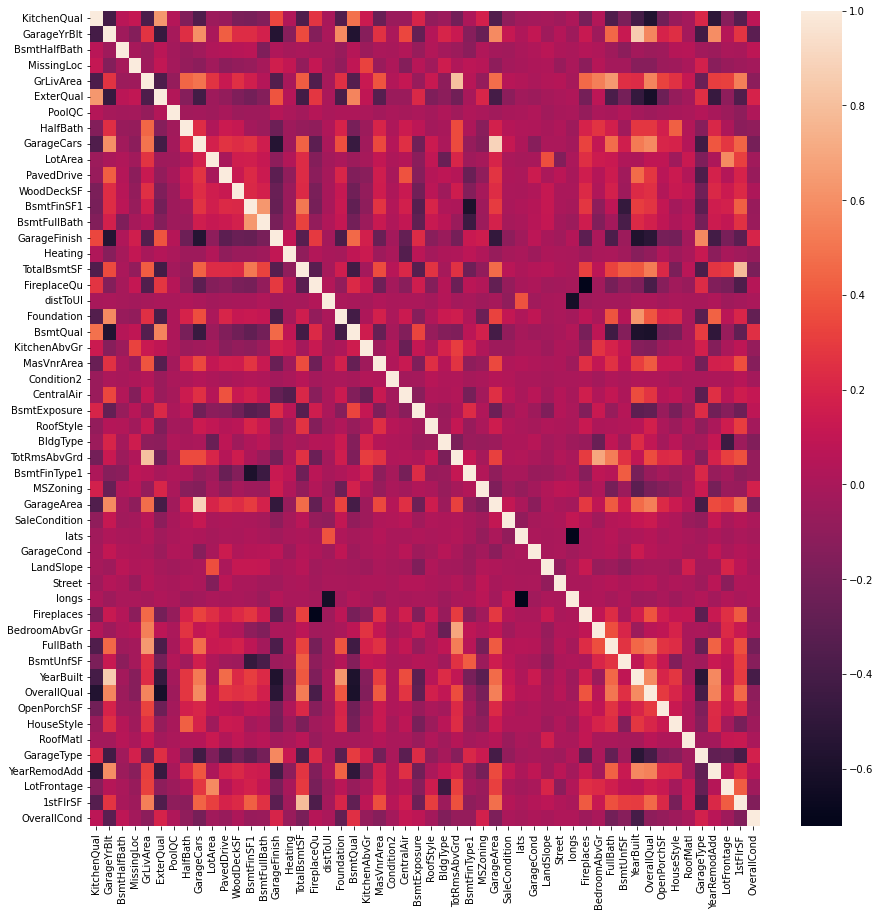

In [247]:
sns.heatmap(alldata[cols_selected].corr())